In [36]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [44]:
class Encoder(nn.Module):

  def __init__(self, encoded_space_dim):
    super().__init__()

    # conv2d -> input_channel, output_channel, kernel_size
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True)
    )

    # start dim tells us from which dimension to start
    # flattening
    self.flatten = nn.Flatten(start_dim=1)

    self.encoder_lin = nn.Sequential(
        nn.Linear(3*3*32,128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
    )

  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [45]:
encoder = Encoder(4)

In [46]:
encoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [47]:
class Decoder(nn.Module):

  def __init__(self, encoded_space_dim):
    super().__init__()
    self.decoder_lin = nn.Sequential(
        nn.Linear(encoded_space_dim, 128),
        nn.ReLU(True),
        nn.Linear(128, 3*3*32),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1,
                                  unflattened_size=(32,3,3))
    
    # ConvTranspose2d -> input_channels, output_channels, kernel_size
    # output_padding -> controls the output padding
    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1,
                           output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1,
                           output_padding=1)
    )

  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [48]:
decoder = Decoder(4)

In [49]:
decoder

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [51]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [52]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
  encoder.train()
  decoder.train()

  train_loss = []

  for image_batch, _ in dataloader: # ignore the labels
    image_batch = image_batch.to(device)

    encoded_data = encoder(image_batch)
    decoded_data = decoder(encoded_data)

    loss = loss_fn(decoded_data, image_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('\t partial train loss (single batch): %f ' % (loss.data))
    train_loss.append(loss.detach().cpu().numpy())

  return np.mean(train_loss)

In [53]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
  encoder.eval()
  decoder.eval()

  with torch.no_grad(): # no need to track the gradients
    conc_out = []
    conc_label = []

    for image_batch, _ in dataloader:
      image_batch = image_batch.to(device)

      encoded_data = encoder(image_batch)

      decoded_data = decoder(encoded_data)

      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())

    # create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)

    # evaluate global loss
    val_loss = loss_fn(conc_out, conc_label)

  return val_loss.data

In [54]:
num_epochs = 30
dict_loss = {
    'train_loss':[],
    'val_loss':[]
}

for epoch in range(num_epochs):
  train_loss = train_epoch(encoder, decoder, device,
                           train_loader, loss_fn, optim)
  
  val_loss = test_epoch(encoder, decoder, device,
                        val_loader, loss_fn)
  

  print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch+1,
                                                                num_epochs,
                                                                train_loss,
                                                                val_loss))
  

  dict_loss['train_loss'].append(train_loss)
  dict_loss['val_loss'].append(val_loss)

Streaming output truncated to the last 5000 lines.
	 partial train loss (single batch): 0.035508 
	 partial train loss (single batch): 0.035728 
	 partial train loss (single batch): 0.035138 
	 partial train loss (single batch): 0.034836 
	 partial train loss (single batch): 0.034859 
	 partial train loss (single batch): 0.034414 
	 partial train loss (single batch): 0.035046 
	 partial train loss (single batch): 0.036565 
	 partial train loss (single batch): 0.032647 
	 partial train loss (single batch): 0.035048 
	 partial train loss (single batch): 0.032931 
	 partial train loss (single batch): 0.033641 
	 partial train loss (single batch): 0.033423 
	 partial train loss (single batch): 0.034425 
	 partial train loss (single batch): 0.033961 
	 partial train loss (single batch): 0.033451 
	 partial train loss (single batch): 0.033266 
	 partial train loss (single batch): 0.034562 
	 partial train loss (single batch): 0.034763 
	 partial train loss (single batch): 0.034863 
	 partial

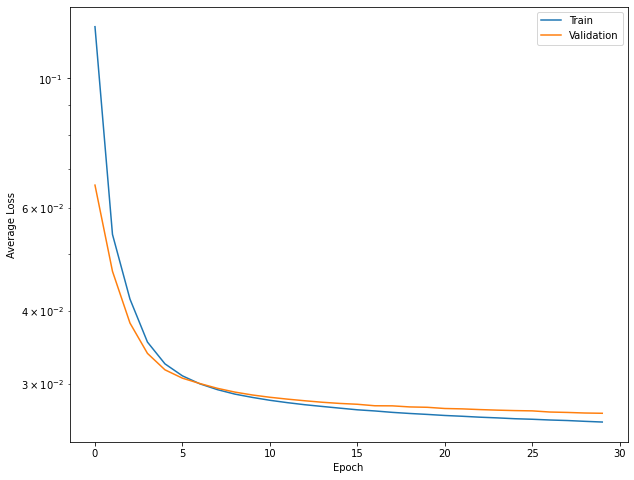

In [43]:
plt.figure(figsize=(10,8))

plt.semilogy(dict_loss['train_loss'], label='Train')
plt.semilogy(dict_loss['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

tensor([-0.0949,  0.1071, -0.0748, -0.0246])
tensor([0.6982, 0.6431, 0.6506, 0.6515])


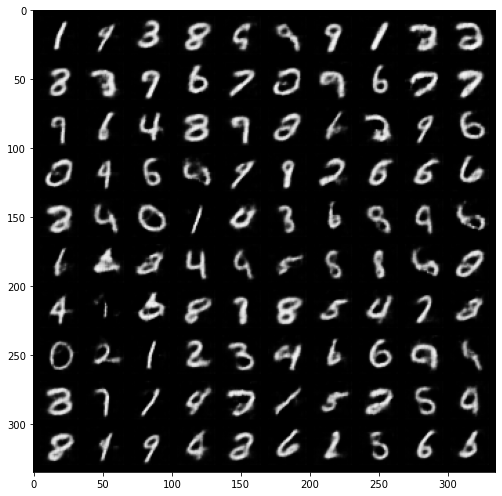

In [24]:
def show_image(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
  # calculate the mean and std of the latent space
  images, labels = next(iter(test_loader))
  images = images.to(device)
  latent = encoder(images)
  latent = latent.cpu()

  mean = latent.mean(dim=0)
  print(mean)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()
  print(std)

  # sample latent vectors from the normal distribution
  latent = torch.randn(128, d)*std + mean

  # reconstruct images from the random latent vectors
  latent = latent.to(device)
  img_recon = decoder(latent)
  img_recon = img_recon.cpu()

  fig, ax = plt.subplots(figsize=(20,8.5))
  show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
  plt.show()

In [26]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(test_dataset):
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]

  encoder.eval()
  with torch.no_grad():
    encoded_img = encoder(img)

  # append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_sample = {f'Enc. Variable {i}': enc for i, enc in enumerate(encoded_img)}
  encoded_sample['label'] = label
  encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:09<00:00, 1006.57it/s]


In [27]:
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.059634,1.510498,-0.213134,0.183364,7
1,0.269593,0.610585,0.608468,0.672712,2
2,-0.175597,0.748375,-0.864148,1.184101,1
3,-0.089791,-0.805797,0.202507,-0.655394,0
4,-0.237058,-0.055593,-1.252200,-0.921084,4
...,...,...,...,...,...
9995,-0.448629,0.563236,0.847185,0.671874,2
9996,0.513956,0.425821,0.830639,0.086022,3
9997,-0.804952,0.030695,-1.315594,0.050942,4
9998,-0.336645,-0.782368,-0.116049,0.276208,5


In [28]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=.7)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))

fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

